<a href="https://colab.research.google.com/github/Berkay86/DeepPerson/blob/main/CHESSGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import zipfile
import os

# Zip dosyasını aç
with zipfile.ZipFile("Videolarım.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Klasörlerin adlarını saklamak için bir liste oluştur
folder_names = []

# Zip dosyasındaki her dosya için
for file in os.listdir():
    if file.endswith(".mp4"):
        # Video dosyasını aç
        cap = cv2.VideoCapture(file)

        # Klasör adı oluştur
        folder_name = os.path.splitext(file)[0]
        folder_names.append(folder_name)

        # Klasör oluştur
        os.makedirs(folder_name)

        # Her frame için
        i = 0
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == False:
                break
            
            # Sadece 5., 6., 7., ... sn'lik frame'leri kaydet
            if i % 30 == 0:
                cv2.imwrite(folder_name + "/" + folder_name + str(i) + '.jpg', frame)
            i += 1

        # Video dosyasını kapat
        cap.release()
        cv2.destroyAllWindows()



# Tüm klasörleri ve içeriğini bir zip dosyasına kaydet
with zipfile.ZipFile("result.zip", 'w') as zip_file:
    for folder_name in folder_names:
        for root, dirs, files in os.walk(folder_name):
            for file in files:
                zip_file.write(os.path.join(root, file))

In [11]:
import glob
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from zipfile import ZipFile
from google.colab import files
import os
     

In [14]:
file2 = "/content/drive/MyDrive/RESULTS1.zip"

In [15]:
with ZipFile(file2, 'r') as zip:
    zip.printdir()
    zip.extractall()
     

File Name                                             Modified             Size
RESULTS/                                       2023-02-13 15:22:30            0
RESULTS/AnderssenStaunton/                     2023-02-13 15:22:30            0
RESULTS/AnderssenStaunton/AnderssenStaunton0.jpg 2023-02-13 12:16:24       101042
RESULTS/AnderssenStaunton/AnderssenStaunton1020.jpg 2023-02-13 12:16:26       111875
RESULTS/AnderssenStaunton/AnderssenStaunton1050.jpg 2023-02-13 12:16:26       111967
RESULTS/AnderssenStaunton/AnderssenStaunton1080.jpg 2023-02-13 12:16:26       112038
RESULTS/AnderssenStaunton/AnderssenStaunton1110.jpg 2023-02-13 12:16:26       112150
RESULTS/AnderssenStaunton/AnderssenStaunton1140.jpg 2023-02-13 12:16:26       112148
RESULTS/AnderssenStaunton/AnderssenStaunton1170.jpg 2023-02-13 12:16:26       111404
RESULTS/AnderssenStaunton/AnderssenStaunton120.jpg 2023-02-13 12:16:24       116563
RESULTS/AnderssenStaunton/AnderssenStaunton1200.jpg 2023-02-13 12:16:26       111240

In [16]:
paths = os.listdir('RESULTS')
paths

['StauntonAnderssen',
 'PaulsenMorphy',
 'PaulsenMorphy4',
 'StauntonAnderssen1',
 'AnderssenStaunton1',
 'MorphyPaulsen4',
 'MorphyPaulsen2',
 'MorphyPaulsen',
 'MorphyPaulsen3',
 'MorphyBird',
 'PaulsenMorphy1',
 'StauntonBird',
 'MorphyPaulsen1',
 'BirdAnderssen',
 'PaulsenMorphy3',
 'PaulsenMorphy2',
 'MorphyPaulsen5',
 'AnderssenStaunton2',
 'BirdAnderssen1',
 'AnderssenStaunton']

In [17]:
k=[]
images = []
labels = []
m=[] 
a=[] 
     

In [18]:
for i in paths:
    path0 = '/content/RESULTS/'+ str(i)
    for path in os.listdir(path0):
        path = '/content/RESULTS/'+ str(i) + "/" + path
        #print(path)
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(64,64),interpolation= cv2.INTER_AREA)
        img = img/255.0
        images.append(img)
        label = path.split("")

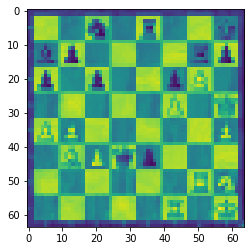

In [23]:
plt.imshow(images[3])